In [1]:
import cloudViewer as cv3d
import numpy as np
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('../..')
import cloudViewer_tutorial as cv3dtut
# change to True if you want to interact with the visualization windows
cv3dtut.interactive = not "CI" in os.environ

# Multiway registration
Multiway registration is the process of aligning multiple pieces of geometry in a global space. Typically, the input is a set of geometries (e.g., point clouds or RGBD images) $\{\mathbf{P}_{i}\}$. The output is a set of rigid transformations $\{\mathbf{T}_{i}\}$, so that the transformed point clouds $\{\mathbf{T}_{i}\mathbf{P}_{i}\}$ are aligned in the global space.

CloudViewer implements multiway registration via pose graph optimization. The backend implements the technique presented in [\[Choi2015\]](../reference.html#choi2015).

## Input
The first part of the tutorial code reads three point clouds from files. The point clouds are downsampled and visualized together. They are misaligned.

In [2]:
def load_point_clouds(voxel_size=0.0):
    pcds = []
    for i in range(3):
        pcd = cv3d.io.read_point_cloud("../../../TestData/ICP/cloud_bin_%d.pcd" %
                                      i)
        pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
        pcds.append(pcd_down)
    return pcds

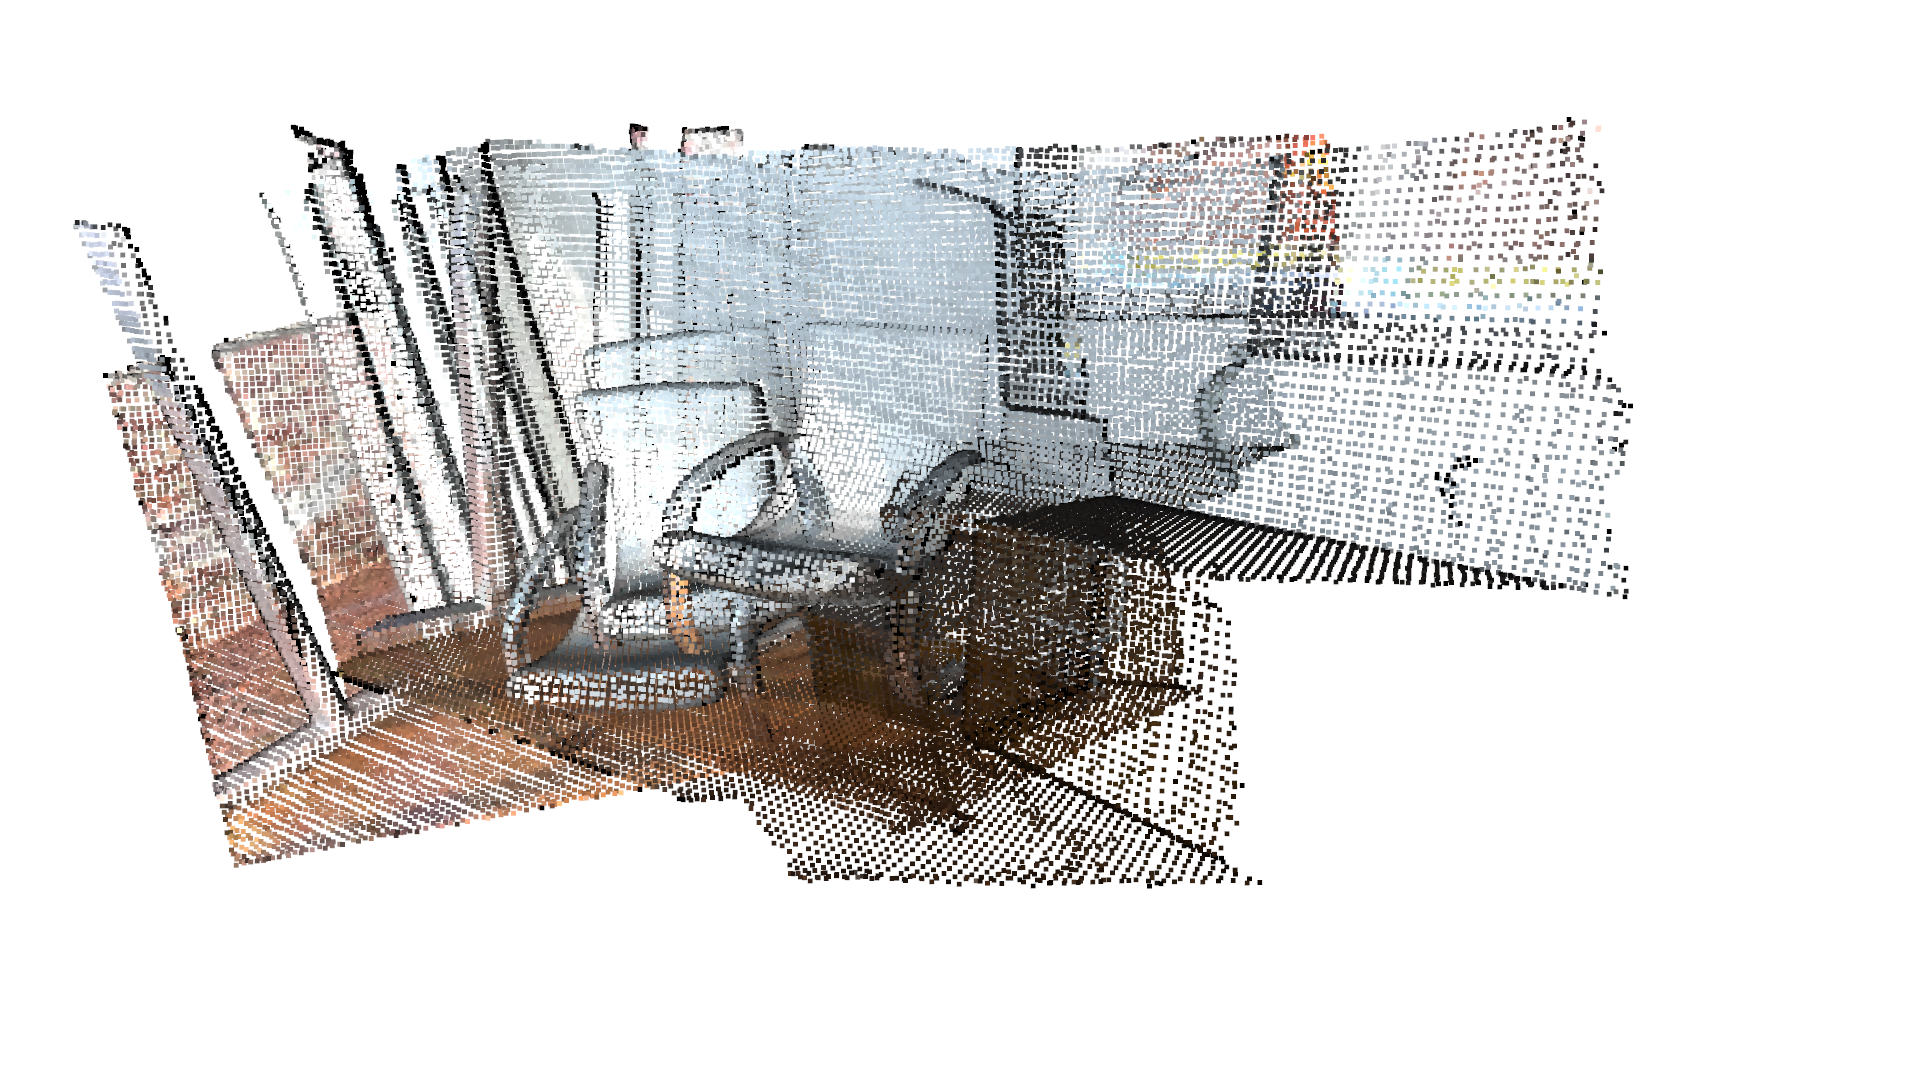

In [3]:
voxel_size = 0.02
pcds_down = load_point_clouds(voxel_size)
cv3d.visualization.draw_geometries(pcds_down,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

## Pose graph
A pose graph has two key elements: nodes and edges. A node is a piece of geometry $\mathbf{P}_{i}$ associated with a pose matrix $\mathbf{T}_{i}$ which transforms $\mathbf{P}_{i}$ into the global space. The set $\{\mathbf{T}_{i}\}$ are the unknown variables to be optimized. `PoseGraph.nodes` is a list of `PoseGraphNode`. We set the global space to be the space of $\mathbf{P}_{0}$. Thus $\mathbf{T}_{0}$ is the identity matrix. The other pose matrices are initialized by accumulating transformation between neighboring nodes. The neighboring nodes usually have large overlap and can be registered with [Point-to-plane ICP](../pipelines/icp_registration.ipynb#point-to-plane-ICP).

A pose graph edge connects two nodes (pieces of geometry) that overlap. Each edge contains a transformation matrix $\mathbf{T}_{i,j}$ that aligns the source geometry $\mathbf{P}_{i}$ to the target geometry $\mathbf{P}_{j}$. This tutorial uses [Point-to-plane ICP](../pipelines/icp_registration.ipynb#point-to-plane-ICP) to estimate the transformation. In more complicated cases, this pairwise registration problem should be solved via [Global registration](global_registration.ipynb).

[\[Choi2015\]](../reference.html#choi2015) has observed that pairwise registration is error-prone. False pairwise alignments can outnumber correctly aligned pairs. Thus, they partition pose graph edges into two classes. **Odometry edges** connect temporally close, neighboring nodes. A local registration algorithm such as ICP can reliably align them. **Loop closure edges** connect any non-neighboring nodes. The alignment is found by global registration and is less reliable. In CloudViewer, these two classes of edges are distinguished by the `uncertain` parameter in the initializer of `PoseGraphEdge`.

In addition to the transformation matrix $\mathbf{T}_{i}$, the user can set an information matrix $\mathbf{\Lambda}_{i}$ for each edge. If $\mathbf{\Lambda}_{i}$ is set using function `get_information_matrix_from_point_clouds`, the loss on this pose graph edge approximates the RMSE of the corresponding sets between the two nodes, with a line process weight. Refer to Eq (3) to (9) in [\[Choi2015\]](../reference.html#choi2015) and [the Redwood registration benchmark](http://redwood-data.org/indoor/registration.html) for details.

The script creates a pose graph with three nodes and three edges. Among the edges, two of them are odometry edges (`uncertain = False`) and one is a loop closure edge (`uncertain = True`).

In [5]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = cv3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        cv3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = cv3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        cv3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = cv3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = cv3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(cv3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build cv3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    cv3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    cv3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    cv3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [6]:
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
with cv3d.utility.VerbosityContextManager(
        cv3d.utility.VerbosityLevel.Debug) as cm:
    pose_graph = full_registration(pcds_down,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
Build cv3d.pipelines.registration.PoseGraph
Apply point-to-plane ICP
Build cv3d.pipelines.registration.PoseGraph
Apply point-to-plane ICP
Build cv3d.pipelines.registration.PoseGraph


CloudViewer uses the function `global_optimization` to perform pose graph optimization. Two types of optimization methods can be chosen: `GlobalOptimizationGaussNewton` or `GlobalOptimizationLevenbergMarquardt`. The latter is recommended since it has better convergence property. Class `GlobalOptimizationConvergenceCriteria` can be used to set the maximum number of iterations and various optimization parameters.

Class `GlobalOptimizationOption` defines a couple of options. `max_correspondence_distance` decides the correspondence threshold. `edge_prune_threshold` is a threshold for pruning outlier edges. `reference_node` is the node id that is considered to be the global space.

In [7]:
print("Optimizing PoseGraph ...")
option = cv3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with cv3d.utility.VerbosityContextManager(
        cv3d.utility.VerbosityLevel.Debug) as cm:
    cv3d.pipelines.registration.global_optimization(
        pose_graph,
        cv3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        cv3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)

Optimizing PoseGraph ...


The global optimization performs twice on the pose graph. The first pass optimizes poses for the original pose graph taking all edges into account and does its best to distinguish false alignments among uncertain edges. These false alignments have small line process weights, and they are pruned after the first pass. The second pass runs without them and produces a tight global alignment. In this example, all the edges are considered as true alignments, hence the second pass terminates immediately.

## Visualize optimization
The transformed point clouds are listed and visualized using `draw_geometries`.

Transform points and display
[[1.00000000e+00 2.23934335e-19 2.16840434e-19 1.73472348e-18]
 [7.09390093e-21 1.00000000e+00 0.00000000e+00 1.73472348e-18]
 [1.08420217e-19 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.84019997 -0.14649431  0.52211439  0.3479597 ]
 [ 0.00633287  0.9654042   0.26068108 -0.39443776]
 [-0.54223972 -0.21571775  0.81206031  1.72950477]
 [ 0.          0.          0.          1.        ]]
[[ 0.96274033 -0.07182174  0.26071575  0.37667852]
 [-0.00178405  0.96237939  0.27170336 -0.48969826]
 [-0.27042168 -0.26204491  0.92639332  1.29658054]
 [ 0.          0.          0.          1.        ]]


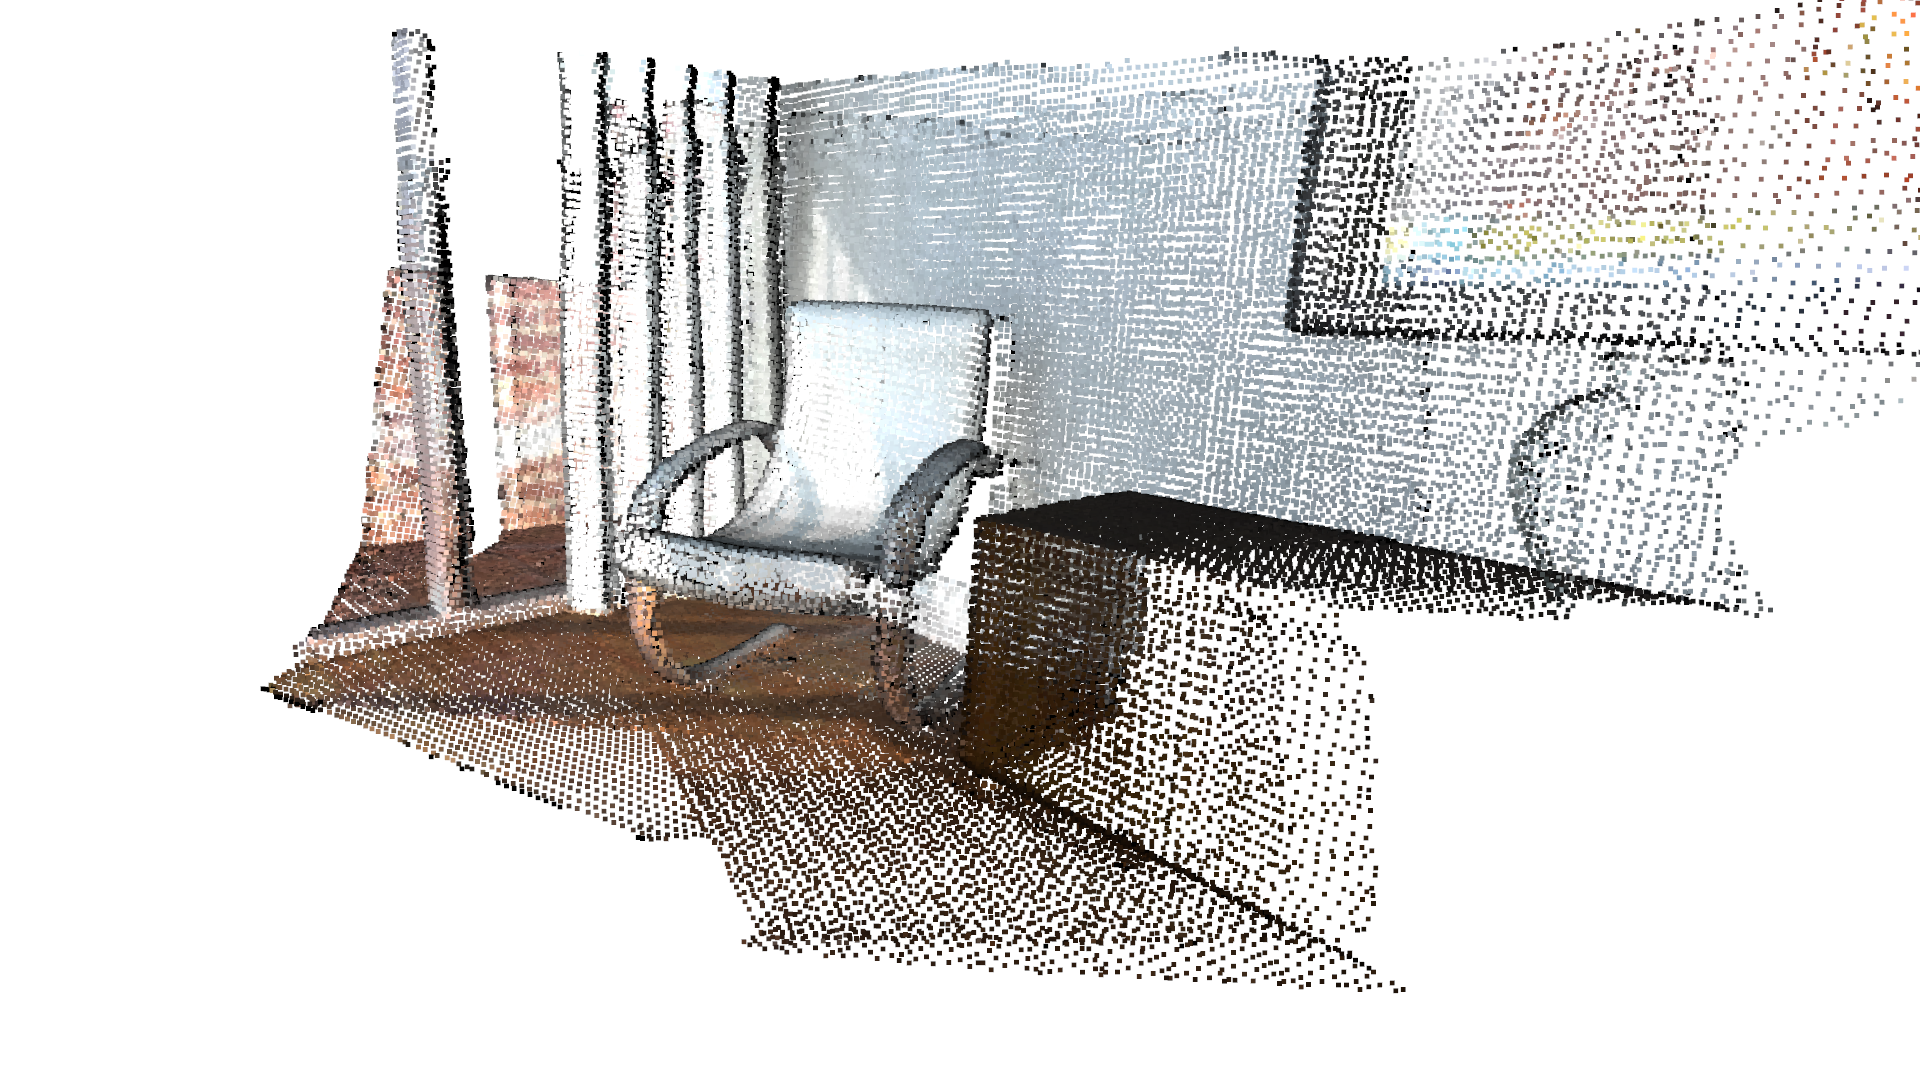

In [8]:
print("Transform points and display")
for point_id in range(len(pcds_down)):
    print(pose_graph.nodes[point_id].pose)
    pcds_down[point_id].transform(pose_graph.nodes[point_id].pose)
cv3d.visualization.draw_geometries(pcds_down,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

## Make a combined point cloud
`PointCloud` has a convenience operator `+` that can merge two point clouds into a single one. In the code below, the points are uniformly resampled using `voxel_down_sample` after merging. This is recommended post-processing after merging point clouds since it can relieve duplicated or over-densified points.

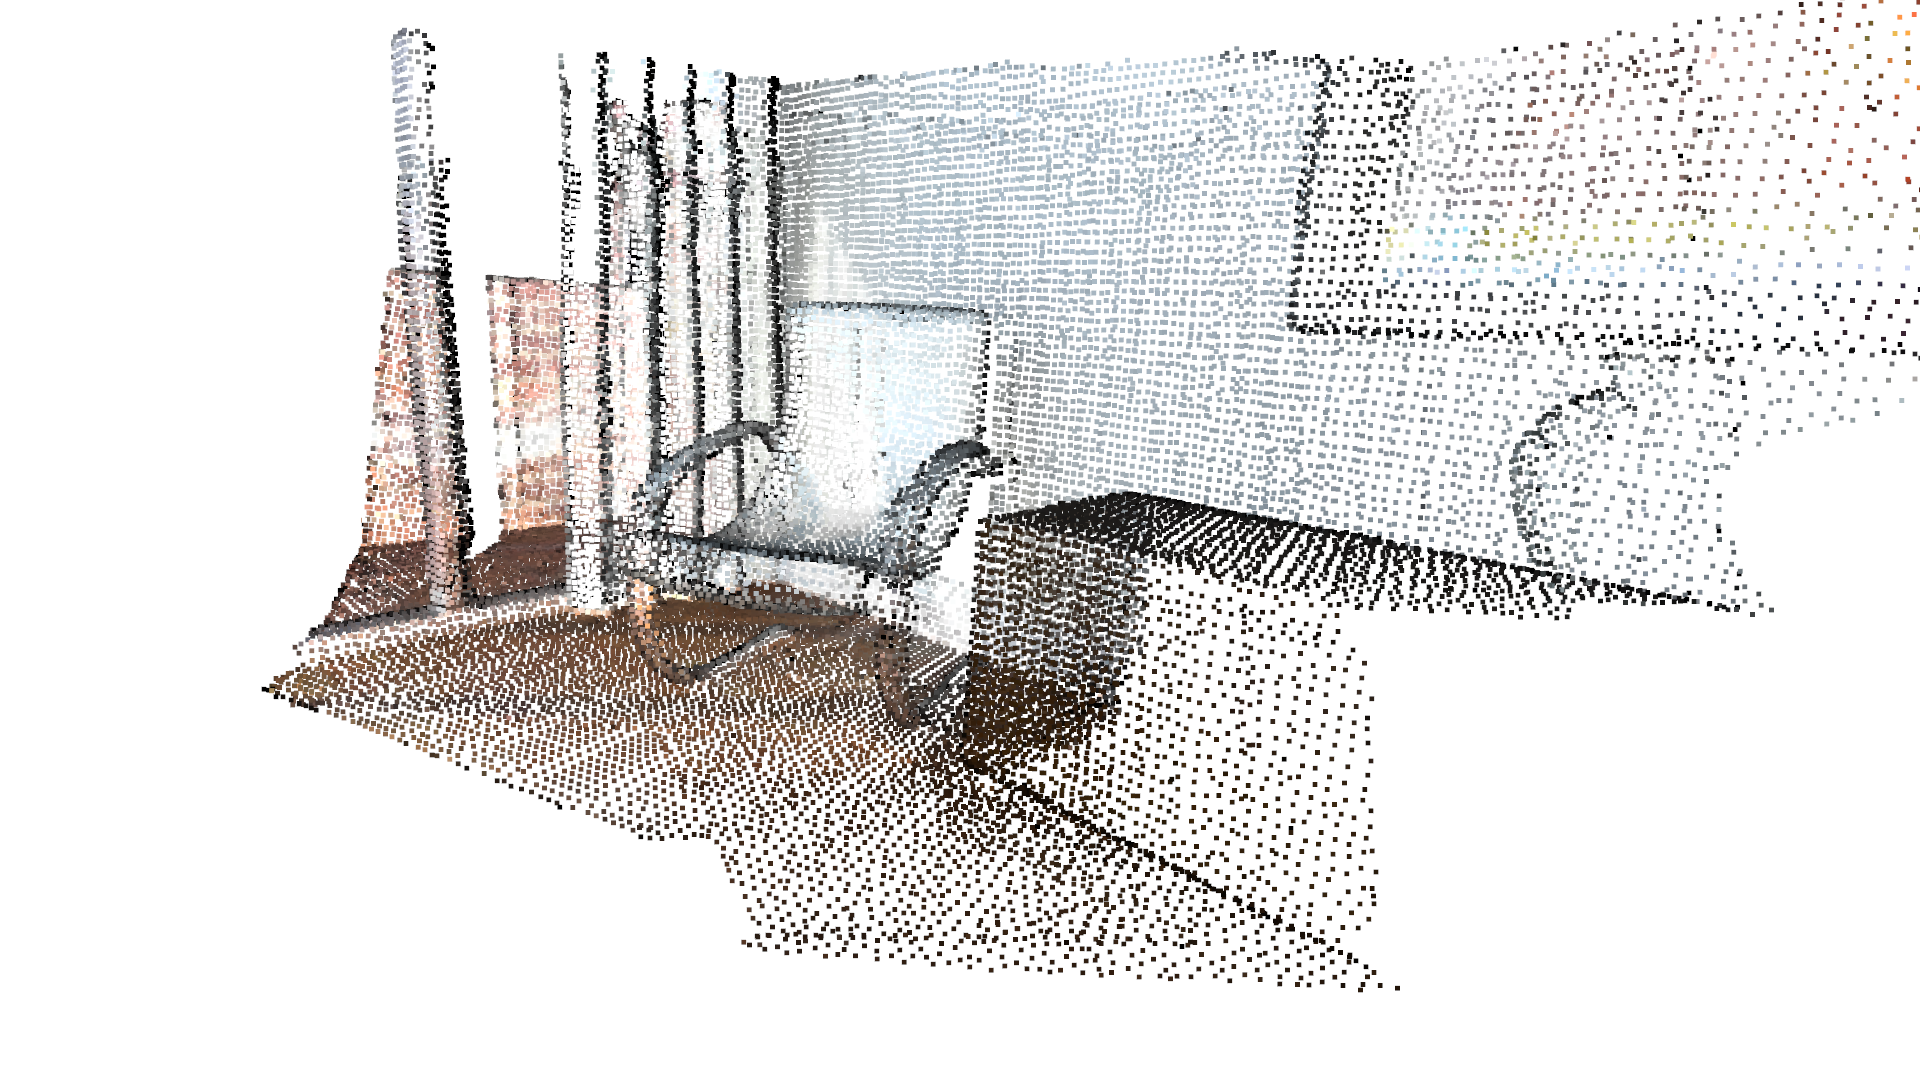

In [9]:
pcds = load_point_clouds(voxel_size)
pcd_combined = cv3d.geometry.ccPointCloud()
for point_id in range(len(pcds)):
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
    pcd_combined += pcds[point_id]
pcd_combined_down = pcd_combined.voxel_down_sample(voxel_size=voxel_size)
cv3d.io.write_point_cloud("multiway_registration.pcd", pcd_combined_down)
cv3d.visualization.draw_geometries([pcd_combined_down],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

<div class="alert alert-info">
    
**Note:**

Although this tutorial demonstrates multiway registration for point clouds, the same procedure can be applied to RGBD images. See [Make fragments](../reconstruction_system/make_fragments.rst) for an example.

</div>